# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

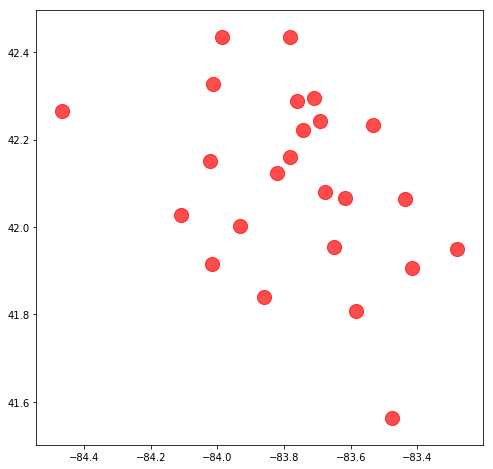

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return plt.show()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

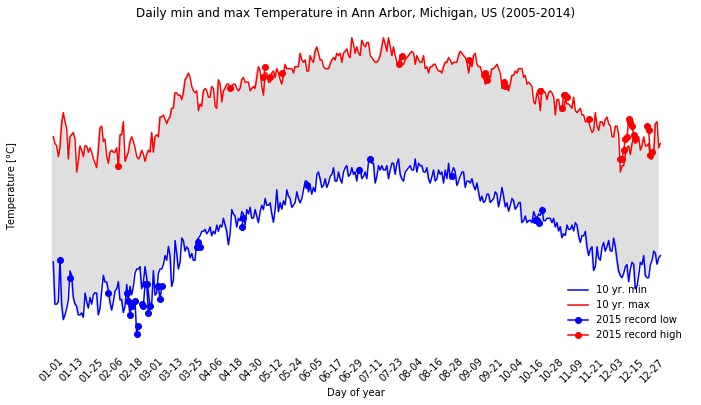

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

#import data
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv', 
                 parse_dates=True)


#add DOY variable and Year Variable
df['RIZI'] = df['Date'].apply(lambda x: x[-5:])
rizi2 = np.array(df['RIZI'].unique())
rizi3 = rizi2[0:365]
rizi3.sort()


df['Date'] = pd.to_datetime(df['Date'])
df['DOY'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day

#add DOY variable and Year Variable


#drop 0229 observations
df=df[~(df['DOY'] ==366)]
df = df.sort_values('Date')
df.index = df['Date']

#add i_2015 indicator in order to partition the dataset into before and after 2015
df['i_2015'] = np.where(df['Year'] == 2015, 1, 0)

#cal min and max by before/after 2015 and DOY
agg = df.groupby(['i_2015','DOY']).agg({
        'Data_Value':[min, max]
        })
agg.reset_index()
agg15=agg.loc[[1],:]
aggbefore15 = agg.loc[[0],:]

#handling multi index/level
aggbefore15.reset_index(level='i_2015', drop = True, inplace=True)
agg15.reset_index(level='i_2015', drop = True, inplace=True)
mergedataset = pd.merge(aggbefore15 , agg15, how='outer', left_index = True, right_index = True)
mergedataset.columns = ( 'min10', 'max10', 'min15', 'max15')


#get obs where year 2015 holds record high or lows
mergedataset['record__min'] = np.where(mergedataset.min15 < mergedataset.min10, mergedataset.min15, np.nan)
mergedataset['record__max'] = np.where(mergedataset.max15 > mergedataset.max10, mergedataset.max15, np.nan)
aggbefore15.columns = aggbefore15.columns.droplevel(level=0)


dfmin = aggbefore15['min']
dfmax = aggbefore15['max']
#prepare data arrays for plot
mindata = np.array(dfmin)
maxdata = np.array(dfmax)
Day_of_year = np.arange(1,366)
broke_min_record = np.array(mergedataset.record__min)
broke_max_record = np.array(mergedataset.record__max)



#plot
plt.figure(figsize=(12,6))

plt.plot(Day_of_year, mindata, '-', color = 'blue')
plt.plot(Day_of_year, maxdata, '-', color = 'red')
plt.plot(Day_of_year, broke_min_record, '-o', color = 'blue')
plt.plot(Day_of_year, broke_max_record, '-o', color = 'red')
ax = plt.gca()
plt.gca().fill_between(range(len(mindata)), 
                       mindata, maxdata, 
                       facecolor='grey', 
                       alpha=0.25)


plt.xlabel('Day of year')
ax.set_ylabel('Temperature [°C]')
plt.title('Daily min and max Temperature in Ann Arbor, Michigan, US (2005-2014)')
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
# remove the frame of the chart
plt.xticks(range(0,365, 12), rizi3[0:-1:12])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
for item in ax.xaxis.get_ticklabels():
    item.set_rotation(45)

plt.legend(['10 yr. min', '10 yr. max', '2015 record low', '2015 record high'], frameon=False, loc = 4)

plt.savefig('Assignment 2 - Figure.png')
plt.show()

In [51]:
!ls

Assignment2-DONE (1).ipynb  Matplotlib_3D.ipynb
Assignment2-DONE.ipynb	    moocdata.png
Assignment 2 - Figure.png   readonly
Assignment2.ipynb	    test.png
Assignment3.ipynb	    UnderstandingDistributionsThroughSampling.ipynb
Assignment4.ipynb	    Untitled Folder
data			    Week2-Copy1.ipynb
Dejunking.ipynb		    Week2.ipynb
files.tar.gz		    Week3.ipynb
iris.csv		    Week4.ipynb
